In [1]:
import sys
import os

# Add your project root to sys.path (adjust the path below)
project_root = '/work/pi_shenoy_umass_edu/hshastri/FMaaS-motivation/timeseries/amazon-chronos/src'  # the folder containing 'momentfm'
if project_root not in sys.path:
    sys.path.insert(0, project_root)
os.chdir(f"/work/pi_shenoy_umass_edu/hshastri/FMaaS-motivation/timeseries/amazon-chronos/tasks")

In [2]:
from torch.utils.data import DataLoader
from momentfm.data.classification_dataset import ClassificationDataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from typing import Tuple

import torch
from torch import nn
import os
import random
from argparse import Namespace
from typing import NamedTuple

import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import torch
from chronos import ChronosPipeline

from momentfm.data.informer_dataset import InformerDataset
from torch.utils.data import DataLoader

/home/hshastri_umass_edu/.conda/envs/amazon-chronos/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:

train_dataset = InformerDataset(
    data_split='train', 
    task_name='imputation', 
    data_stride_len=512)
test_dataset = InformerDataset(
    data_split='test', 
    task_name='imputation', 
    data_stride_len=512)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Train dataset size: 16
Test dataset size: 6


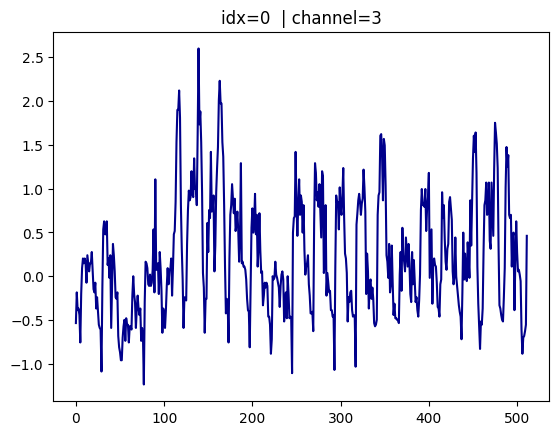

In [4]:
import numpy as np
import matplotlib.pyplot as plt

n_channels = test_dataset[0][0].shape[0]
idx = np.random.randint(0, len(test_dataset))
channel_idx = np.random.randint(0, n_channels)
plt.plot(test_dataset[idx][0][channel_idx, :].squeeze(), c='darkblue')
plt.title(f'idx={idx}  | channel={channel_idx}')
plt.show()

In [5]:
from momentfm.utils.masking import Masking

mask_generator = Masking(mask_ratio=0.25) # Mask 25% of patches randomly

In [6]:
model_name= "amazon/chronos-t5-small"
pipeline = ChronosPipeline.from_pretrained(
    f"{model_name}",
    device_map="cuda",
    torch_dtype=torch.bfloat16,)

output_dim_dir={"amazon/chronos-t5-tiny":256,"amazon/chronos-t5-mini":256,"amazon/chronos-t5-small":512,"amazon/chronos-t5-base":768,"amazon/chronos-t5-large":1024}

In [ ]:
from tqdm import tqdm

device = "cuda:0" if torch.cuda.is_available() else "cpu"

trues, preds, masks = [], [], []
with torch.no_grad():
    for batch_x, batch_masks in test_dataloader:
        batch_x = batch_x.squeeze(1).to(torch.float32)

        mean = batch_x.mean(dim=-1, keepdim=True)
        std = batch_x.std(dim=-1, keepdim=True,unbiased=False) + 1e-6
        batch_x_norm = (batch_x - mean) / std  # shape: [B, 512]


        batch_x_norm = batch_x_norm.reshape((-1, 1, 512)) 
        
        batch_masks = batch_masks.long()
        batch_masks = batch_masks.repeat_interleave(n_channels, axis=0)
        
        mask = mask_generator.generate_mask(batch_x_norm,input_mask=batch_masks)  # Generate mask for the batch
        corrupted_input = batch_x_norm.clone()
        corrupted_input[mask.unsqueeze(1) == 0] = 0.0

        # a. Get embeddings from Chronos
        with torch.no_grad():  # freeze Chronos
            output, tokenizer_state = pipeline.embed(corrupted_input.squeeze(1))
            pred = output.mean(dim=1).to(torch.float32)
        
        pred = pred.reshape((batch_x.shape[0], batch_x.shape[1], batch_x.shape[2]))
        mask= mask.reshape((batch_x.shape[0], batch_x.shape[1], batch_x.shape[2]))
        
        pred=pred*std + mean 
        print(pred)
        preds.append(pred)
        masks.append(mask)
        trues.append(batch_x)

preds = np.concatenate(preds)
trues = np.concatenate(trues)
masks = np.concatenate(masks)

print(preds)
print(f"Shapes: preds={preds.shape} | trues={trues.shape} | masks={masks.shape}")
     


tensor([[-1.8463e-03, -2.5940e-03,  1.1597e-02,  ...,  2.2339e-02,
          6.5613e-03, -3.8910e-04],
        [-4.1199e-03, -2.6703e-03,  4.5471e-03,  ...,  3.0640e-02,
          4.1199e-03,  6.4087e-03],
        [-1.6022e-03, -1.4648e-03,  1.0254e-02,  ...,  2.0752e-02,
          4.0283e-03,  1.6479e-03],
        ...,
        [-4.1485e-05, -6.1417e-04,  6.9885e-03,  ...,  1.3977e-02,
          9.7275e-05,  6.3782e-03],
        [ 1.0132e-02,  3.0518e-03,  4.3335e-03,  ...,  1.5991e-02,
          6.3782e-03,  7.9346e-03],
        [ 1.1536e-02,  1.9836e-03,  7.8125e-03,  ...,  2.1240e-02,
          8.7891e-03,  6.2256e-03]])
tensor([[[-0.4133, -0.4141, -0.3990,  ..., -0.3876, -0.4043, -0.4117],
         [ 0.1614,  0.1626,  0.1683,  ...,  0.1888,  0.1679,  0.1697],
         [-0.3443, -0.3441, -0.3309,  ..., -0.3191, -0.3380, -0.3406],
         ...,
         [-0.5029, -0.4984, -0.4972,  ..., -0.4913, -0.5035, -0.4984],
         [-0.0231, -0.0327, -0.0211,  ..., -0.0197, -0.0360, -0.0318],

In [73]:
from momentfm.utils.forecasting_metrics import mse, mae

print(f"Mean Squarred Error (MSE)={mse(y=trues[masks==0], y_hat=preds[masks==0], reduction='mean')}")
print(f"Mean Absolute Error (MAE)={mae(y=trues[masks==0], y_hat=preds[masks==0], reduction='mean')}")

Mean Squarred Error (MSE)=0.6597190499305725
Mean Absolute Error (MAE)=0.544987142086029


[-0.41326687 -0.41406137 -0.39898235 -0.41136047 -0.39405328 -0.42421132
 -0.4146613  -0.4107618  -0.39924175 -0.39749065 -0.43024296 -0.43024296
 -0.42641643 -0.38523287 -0.42109823 -0.3954801  -0.40316555 -0.41620162
 -0.4311509  -0.3966475  -0.40921336 -0.42829725 -0.4295944  -0.42122796
 -0.39275616 -0.40261427 -0.4286864  -0.418277   -0.42064425 -0.40267912
 -0.4090026  -0.39775008 -0.39716637 -0.40833783 -0.42485988 -0.39171845
 -0.41258588 -0.39911205 -0.39029163 -0.4157152  -0.4327075  -0.42019024
 -0.39911205 -0.4041708  -0.40572736 -0.4055328  -0.41089356 -0.39891747
 -0.4080784  -0.4072839  -0.40254942 -0.41889313 -0.39132932 -0.435172
 -0.4238222  -0.4085648  -0.4040087  -0.4078352  -0.4114448  -0.41266695
 -0.39528555 -0.44658667 -0.41428837 -0.39982545 -0.4041708  -0.39288586
 -0.3996309  -0.41821215 -0.4119211  -0.39580438 -0.4166556  -0.41474235
 -0.44100904 -0.40975654 -0.40170628 -0.4288161  -0.4067975  -0.40563008
 -0.39807436 -0.42343307 -0.40673262 -0.4126183  -0.4

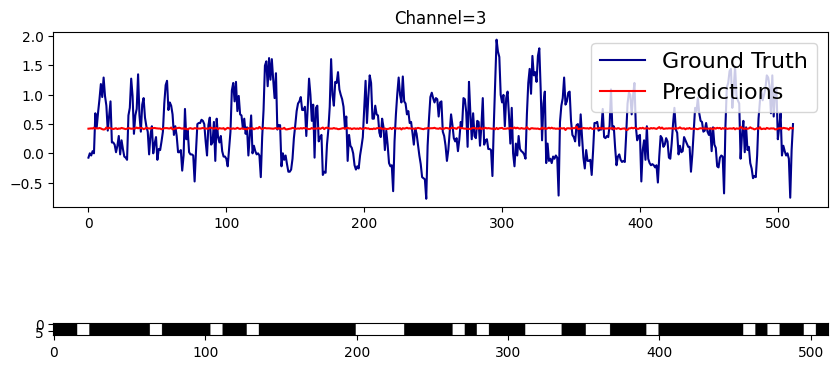

In [ ]:
idx = np.random.randint(trues.shape[0])
channel_idx = np.random.randint(trues.shape[1])

fig, axs = plt.subplots(2, 1, figsize=(10, 5))
axs[0].set_title(f"Channel={channel_idx}")
axs[0].plot(trues[idx, channel_idx, :].squeeze(), label='Ground Truth', c='darkblue')
axs[0].plot(preds[idx, channel_idx, :].squeeze(), label='Predictions', c='red')
axs[0].legend(fontsize=16)

axs[1].imshow(np.tile(masks[np.newaxis, idx, channel_idx], reps=(8, 1)), cmap='binary')
plt.show()

In [57]:
import torch.optim as optim
from momentfm.utils.masking import Masking

class ChronosHead(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super().__init__()
        self.head = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, output_dim),
        )

    def forward(self, x):
        return self.head(x)
    
model_dim = output_dim_dir[f'{model_name}']  # e.g., tiny=512, small=1024, base=2048
output_dim =  512  # regression (set to num_classes for classification)
head = ChronosHead(model_dim, output_dim)

# Optimize Mean Squarred Error using your favourite optimizer 
optimizer = torch.optim.Adam(head.parameters(), lr=1e-2)

mask_generator = Masking(mask_ratio=0.3)
# 4. Training loop
head.train()
for epoch in range(200):
    epoch_loss = 0.0
    for batch_x, batch_masks in train_dataloader:
        batch_x = batch_x.squeeze(1).to(torch.float32)
        mean = batch_x.mean(dim=-1, keepdim=True)
        std = batch_x.std(dim=-1, keepdim=True,unbiased=False) + 1e-6
        batch_x_norm = (batch_x - mean) / std  # shape: [B, 512]
        
        batch_x_norm = batch_x_norm.reshape((-1, 1, 512))
        batch_masks = batch_masks.long()
        batch_masks = batch_masks.repeat_interleave(n_channels, axis=0)
        
        mask = mask_generator.generate_mask(batch_x_norm,input_mask=batch_masks)  # Generate mask for the batch
        corrupted_input = batch_x_norm.clone()
        corrupted_input[mask.unsqueeze(1) == 0] = 0.0
        # a. Get embeddings from Chronos
        with torch.no_grad():  # freeze Chronos
            output, tokenizer_state = pipeline.embed(corrupted_input.squeeze(1))
            embedding = output.mean(dim=1).to(torch.float32)
        pred = head(embedding)
        batch_x_norm=batch_x_norm.squeeze(1)
        
        recon_loss = (pred - batch_x_norm) ** 2  
        observed_mask = batch_masks * (1 - mask)
        masked_loss = observed_mask * recon_loss
        loss = masked_loss.nansum() / (observed_mask.nansum() + 1e-7)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"Loss: {loss.item():.4f}")





Loss: 1.0167
Loss: 1.0043
Loss: 0.9570
Loss: 0.9772
Loss: 0.9937
Loss: 0.9774
Loss: 0.9842
Loss: 0.9736
Loss: 0.9314
Loss: 0.9404
Loss: 0.9816
Loss: 0.9637
Loss: 0.9305
Loss: 0.9438
Loss: 0.9407
Loss: 0.9417
Loss: 0.8868
Loss: 0.8965
Loss: 0.9031
Loss: 0.9176
Loss: 0.9001
Loss: 0.8433
Loss: 0.8877
Loss: 0.9182
Loss: 0.8796
Loss: 0.8898
Loss: 0.8790
Loss: 0.8534
Loss: 0.8588
Loss: 0.8848
Loss: 0.8585
Loss: 0.8634
Loss: 0.8507
Loss: 0.8633
Loss: 0.8817
Loss: 0.8538
Loss: 0.8454
Loss: 0.8258
Loss: 0.8808
Loss: 0.8488
Loss: 0.8344
Loss: 0.8651
Loss: 0.8518
Loss: 0.8262
Loss: 0.8362
Loss: 0.8545
Loss: 0.8016
Loss: 0.8338
Loss: 0.8472
Loss: 0.8294
Loss: 0.8333
Loss: 0.8065
Loss: 0.8315
Loss: 0.8037
Loss: 0.8115
Loss: 0.8107
Loss: 0.8166
Loss: 0.8174
Loss: 0.7896
Loss: 0.7777
Loss: 0.7758
Loss: 0.7912
Loss: 0.7960
Loss: 0.7708
Loss: 0.7804
Loss: 0.7387
Loss: 0.7825
Loss: 0.7631
Loss: 0.7516
Loss: 0.7519
Loss: 0.7687
Loss: 0.7630
Loss: 0.7724
Loss: 0.7620
Loss: 0.7643
Loss: 0.7598
Loss: 0.7135

In [58]:
from tqdm import tqdm

device = "cuda:0" if torch.cuda.is_available() else "cpu"

trues, preds, masks = [], [], []
with torch.no_grad():
    for batch_x, batch_masks in test_dataloader:
        batch_x = batch_x.squeeze(1).to(torch.float32)

        mean = batch_x.mean(dim=-1, keepdim=True)
        std = batch_x.std(dim=-1, keepdim=True,unbiased=False) + 1e-6
        batch_x_norm = (batch_x - mean) / std  # shape: [B, 512]


        batch_x_norm = batch_x_norm.reshape((-1, 1, 512)) 
        
        batch_masks = batch_masks.long()
        batch_masks = batch_masks.repeat_interleave(n_channels, axis=0)
        
        mask = mask_generator.generate_mask(batch_x_norm,input_mask=batch_masks)  # Generate mask for the batch
        corrupted_input = batch_x_norm.clone()
        corrupted_input[mask.unsqueeze(1) == 0] = 0.0

        # a. Get embeddings from Chronos
        with torch.no_grad():  # freeze Chronos
            output, tokenizer_state = pipeline.embed(corrupted_input.squeeze(1))
            embedding = output.mean(dim=1).to(torch.float32)
            
        pred = head(embedding)
        pred = pred.reshape((batch_x.shape[0], batch_x.shape[1], batch_x.shape[2]))
        mask= mask.reshape((batch_x.shape[0], batch_x.shape[1], batch_x.shape[2]))
        
        pred=pred*std + mean 
        preds.append(pred)
        masks.append(mask)
        trues.append(batch_x)

preds = np.concatenate(preds)
trues = np.concatenate(trues)
masks = np.concatenate(masks)

print(f"Shapes: preds={preds.shape} | trues={trues.shape} | masks={masks.shape}")
     


Shapes: preds=(6, 7, 512) | trues=(6, 7, 512) | masks=(6, 7, 512)


In [59]:
from momentfm.utils.forecasting_metrics import mse, mae

print(f"Mean Squarred Error (MSE)={mse(y=trues[masks==0], y_hat=preds[masks==0], reduction='mean')}")
print(f"Mean Absolute Error (MAE)={mae(y=trues[masks==0], y_hat=preds[masks==0], reduction='mean')}")

Mean Squarred Error (MSE)=0.7407287955284119
Mean Absolute Error (MAE)=0.590223491191864


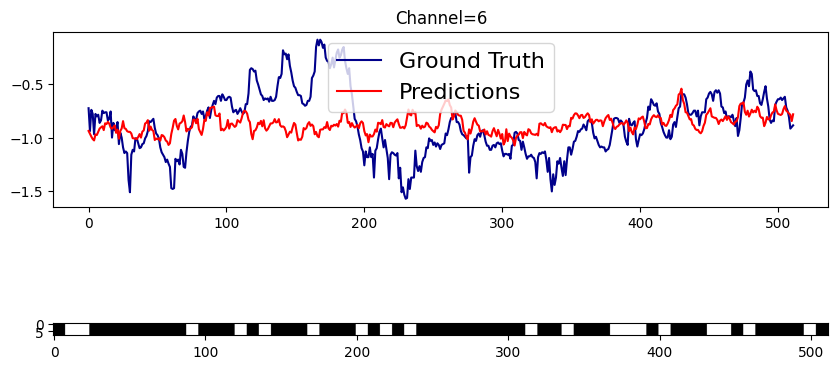

In [65]:
idx = np.random.randint(trues.shape[0])
channel_idx = np.random.randint(trues.shape[1])
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
axs[0].set_title(f"Channel={channel_idx}")
axs[0].plot(trues[idx, channel_idx, :].squeeze(), label='Ground Truth', c='darkblue')
axs[0].plot(preds[idx, channel_idx, :].squeeze(), label='Predictions', c='red')
axs[0].legend(fontsize=16)

axs[1].imshow(np.tile(masks[np.newaxis, idx, channel_idx], reps=(8, 1)), cmap='binary')
plt.show()